In [154]:
from math import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

years = [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
population = [92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906]

future_year = 2010
future_population = 308745538

def get_formatter(order):
    return FuncFormatter(lambda x, pos: f"{(x / 10**order):.0f}")

def extrapolate(name, model, years, population, future_year, future_population):
    xs = [x for x in range(min(years) - 5, future_year + 6)]
    ys = [model(year) for year in xs]
    plt.title(name)
    plt.xlabel("year")
    plt.ylabel("population, $10^6$")
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='both')
    ax.yaxis.set_major_formatter(get_formatter(6))
    plt.plot(xs, ys, color="#8B0000")
    plt.stem(years, population, markerfmt='.')
    plt.stem([future_year], [future_population], markerfmt='gD', basefmt="--")
    deviation = abs(model(future_year) - future_population)
    plt.figtext(0.5, -0.05, f"deviation: {deviation:.0f}({(deviation / future_population * 100):.2f}%)", ha='center', fontsize=12)
    plt.show()

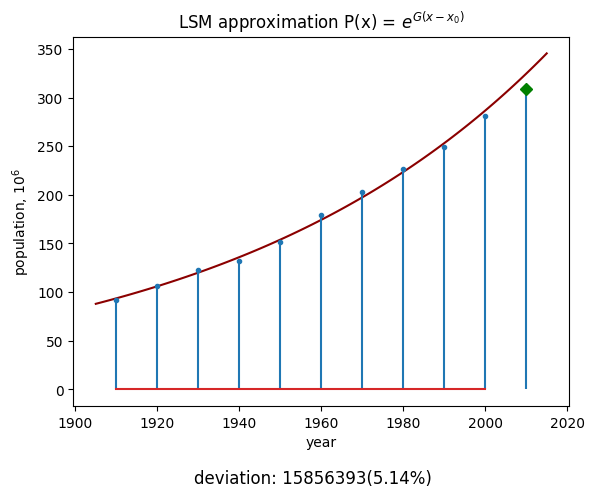

In [155]:
def check_args(xs, ys):
    if len(xs) != len(ys):
        raise Exception(f"len(xs) = {len(xs)} != {len(ys)} = len(ys)")
    
class LinearFunciton:
    pass

class ExponentialFunction:
    pass

# P(x) = ax + b
# returns tuple (a, b)
def get_linear_LSM_coefficients(xs : list[float], ys : list[float]) -> tuple[float, float]:
    check_args(xs, ys)
    sum_x = sum(xs)
    sum_y = sum(ys)
    sum_xy = sum(map(lambda x, y: x*y, xs, ys))
    sum_xx = sum(map(lambda x: x*x, xs))
    N = len(xs)
    a = (N * sum_xy - sum_x * sum_y) / (N * sum_xx - sum_x * sum_x)
    b = (sum_y - a * sum_x) / N
    return a, b
    
# P(x) = exp(ax + b)
# returns tuple (a, b)
def get_exponential_LSM_coefficients(xs : list[float], ys : list[float]) -> tuple[float, float]:
    check_args(xs, ys)
    return get_linear_LSM_coefficients(xs, list(map(log, ys)))

# P(x) = ax + b
# returns tuple (a, b)
def get_linear_LSM_function(xs : list[float], ys : list[float]):
    a, b = get_linear_LSM_coefficients(xs, ys)
    return lambda x: a * x + b

# P(x) = exp(ax + b)
# returns tuple (a, b)
def get_exponential_LSM_function(xs : list[float], ys : list[float]) -> tuple[float, float]:
    a, b = get_exponential_LSM_coefficients(xs, ys)
    return lambda x: exp(a * x + b)

approx = get_exponential_LSM_function(years, population)
extrapolate("LSM approximation P(x) = $e^{G(x-x_0)}$", approx, years, population, future_year, future_population)

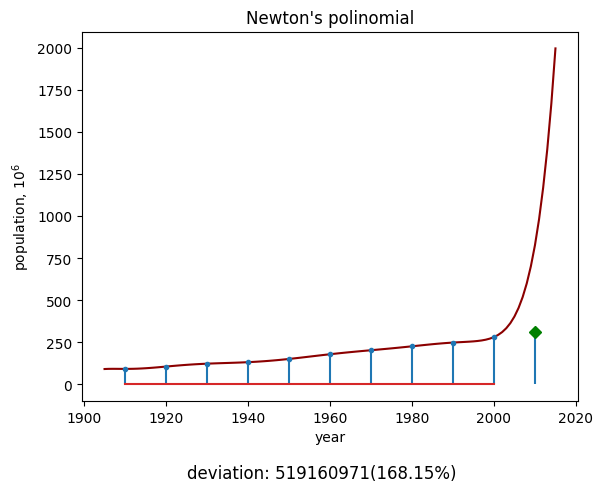

In [156]:
def get_divided_differences(xs, ys):
    n = len(xs)
    table = [[0] * n for _ in range(n)]
    for i in range(n):
        table[i][0] = ys[i]
    for j in range(1, n):
        for i in range(n - j):
            table[i][j] = (table[i+1][j-1] - table[i][j-1]) / (xs[i+j] - xs[i])
    return table

def calc_Newtons_Polynomial(xs, coefs, x):
    result = 0
    for n in range(1, len(coefs)):
        result = (result + coefs[-n]) * (x - xs[-n - 1])
    return coefs[0] + result

def get_Newtons_Polynomial(xs, ys):
    check_args(xs, ys)
    div_diffs = get_divided_differences(xs, ys)
    return lambda x: calc_Newtons_Polynomial(xs, div_diffs[0], x)

def get_N3(xs, ys):
    a = ys[0]
    b = (ys[1] - ys[0]) / (xs[1] - xs[0])
    c = ((ys[2] - ys[1]) / (xs[2] - xs[1]) - b) / (years[2] - years[0])
    return lambda x: a + b*(x - xs[0]) + c*(x - xs[0])*(x - xs[1])

approx = get_Newtons_Polynomial(years, population)
extrapolate("Newton's polinomial", approx, years, population, future_year, future_population)

(174415400.0, 2.1795280032940224e+17, 0.0)
[1.74415571e+08 1.75961460e-02 0.00000000e+00]


C:\Users\MateBook\AppData\Local\Temp\ipykernel_13260\1833886143.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  params, *_ = sopt.curve_fit(np.vectorize(sigmoid), years, population, p0=[0,0,0])


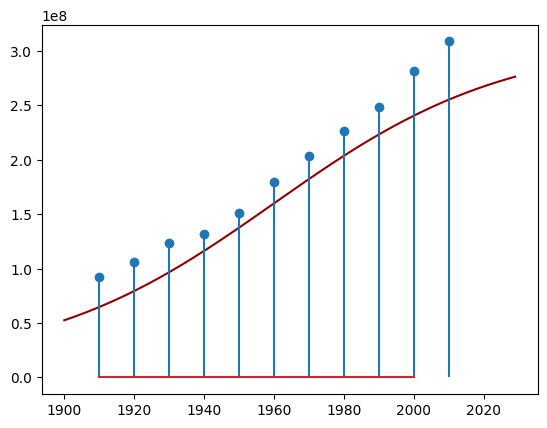

In [157]:
def get_gradient(f, xs, eps = 0.001):
    xs = [x for x in xs]
    n = len(xs)
    gradient = []
    ddx = 2 * eps
    for i in range(n):
        xs[i] += eps
        pos_f = f(*xs)
        xs[i] -= ddx
        neg_f = f(*xs)
        xs[i] += eps
        gradient += [(pos_f - neg_f) / ddx]
    return gradient

# P(t) = K / (1 + e^{-r(t - t0)})
# returns (K, r, t0)
def get_sigmoid_LSM_coefficients(xs : list[float], ys : list[float], step, iterations) -> tuple[float, float, float]:
    S = lambda K, r, t0: sum([(y - K / (1 + exp(r*(t0 - t))))**2 for t,y in zip(xs, ys)])
    K = 0
    r = 0
    t0 = 0
    for i in range(iterations):
        gd = get_gradient(S, (K, r, t0))
        K -= step * gd[0]
        r -= step * gd[1]
        t0 -= step * gd[2]
    return K, r, t0

def get_sigmoid(K, r, t0):
    return lambda t: K / (1 + exp(r*(t0 - t)))

print(get_sigmoid_LSM_coefficients(years, population, 0.01, 100))

def sigmoid(t, K, r, t0):
    return K / (1 + exp(r*(t0 - t)))

import scipy.optimize as sopt
import numpy as np
params, *_ = sopt.curve_fit(np.vectorize(sigmoid), years, population, p0=[0,0,0])
print(params)
approx = get_sigmoid(3e8, 0.03, 1960)
xs = [x for x in range(1900, 2030)]
ys = [approx(x) + 1e7 for x in xs]
plt.plot(xs, ys, color="#8B0000")
plt.stem(years, population)
plt.stem([2010], [308745538])
plt.show()

C:\Users\MateBook\AppData\Local\Temp\ipykernel_13260\1137151329.py:7: RuntimeWarning: overflow encountered in exp
  return K * np.exp(r * (x - t0))


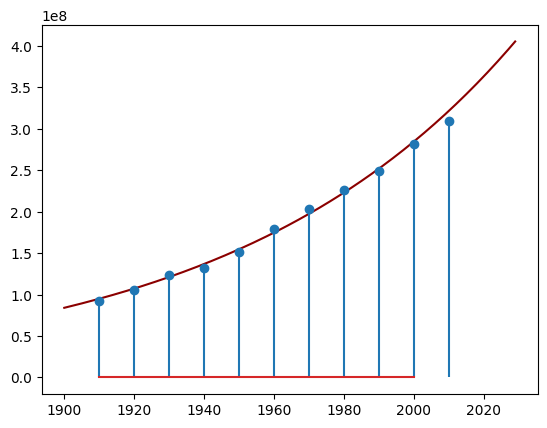

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Определяем сигмоидальную функцию
def sigmoid(x, K, r, t0):
    return K * np.exp(r * (x - t0))

# Примерные данные (с добавленным шумом)
xdata = years
ydata = population

# Начальные приближения для параметров
p0 = [0, 0, 0]  # K=10, r=1, t0=5

# Используем curve_fit для подбора параметров
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=p0, method='trf')

xs = [x for x in range(1900, 2030)]
ys = [sigmoid(x, *popt) for x in xs]
plt.plot(xs, ys, color="#8B0000")
plt.stem(years, population)
plt.stem([2010], [308745538])
plt.show()

Оптимальные параметры: K=9.909, r=0.984, t0=5.006


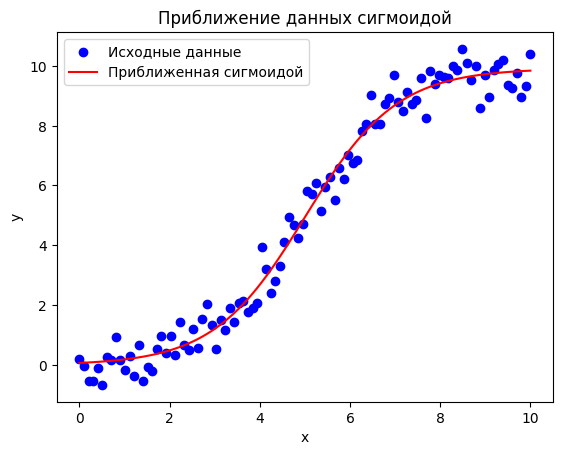

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Определяем сигмоидальную функцию
def sigmoid(x, K, r, t0):
    return K / (1 + np.exp(-r * (x - t0)))

# Примерные данные (с добавленным шумом)
xdata = np.linspace(0, 10, 100)
ydata = sigmoid(xdata, 10, 1, 5) + 0.5 * np.random.normal(size=len(xdata))  # Добавляем шум

# Начальные приближения для параметров
p0 = [10, 1, 5]  # K=10, r=1, t0=5

# Используем curve_fit для подбора параметров
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=p0)

# Оптимальные параметры, полученные после подбора
K_opt, r_opt, t0_opt = popt
print(f"Оптимальные параметры: K={K_opt:.3f}, r={r_opt:.3f}, t0={t0_opt:.3f}")

# Построение графиков
plt.scatter(xdata, ydata, label="Исходные данные", color="blue")
plt.plot(xdata, sigmoid(xdata, *popt), label="Приближенная сигмоидой", color="red")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Приближение данных сигмоидой')
plt.show()